In [1]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from statsmodels.stats.anova import anova_lm

In [2]:
from pygam import s as s_gam, l as l_gam, f as f_gam, LinearGAM, LogisticGAM
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ShuffleSplit, cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, KBinsDiscretizer
from sklearn.model_selection import GridSearchCV


In [3]:
Wage = load_data("Wage")
y = Wage["wage"]
age = Wage["age"]
Wage

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154
...,...,...,...,...,...,...,...,...,...,...,...
2995,2008,44,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,5.041393,154.685293
2996,2007,30,2. Married,1. White,2. HS Grad,2. Middle Atlantic,1. Industrial,2. >=Very Good,2. No,4.602060,99.689464
2997,2005,27,2. Married,2. Black,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.193125,66.229408
2998,2005,27,1. Never Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,4.477121,87.981033


### a)

In [4]:
poly = PolynomialFeatures(include_bias=False)
ols = LinearRegression()

poly_pipe = make_pipeline(poly, ols)

grid_search_poly = GridSearchCV(
    estimator=poly_pipe,
    param_grid={"polynomialfeatures__degree": [1, 2, 3, 4, 5]},
    cv=5,
    scoring="neg_mean_squared_error",
    verbose=1,
)

outer_valid = ShuffleSplit(n_splits=1, test_size=0.20, random_state=2)

result_poly = cross_validate(
    grid_search_poly,
    pd.DataFrame({"age": age}),
    y,
    cv=outer_valid,
    scoring="neg_mean_squared_error",
    return_estimator=True,
)

print(result_poly)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'fit_time': array([0.08418632]), 'score_time': array([0.00100017]), 'estimator': [GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures(include_bias=False)),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'polynomialfeatures__degree': [1, 2, 3, 4, 5]},
             scoring='neg_mean_squared_error', verbose=1)], 'test_score': array([-1567.80980677])}


In [5]:
result_poly["estimator"][0].best_params_

{'polynomialfeatures__degree': 3}

In [6]:
poly_estimator = result_poly["estimator"][0].best_estimator_

In [7]:
age_grid = np.linspace(age.min(), age.max(), 100)

age_df = pd.DataFrame({"age": age_grid})

In [8]:
def plot_wage_fit(age_df, y, x, estimator, title):
    preds = estimator.predict(age_df)
    fig, ax = subplots(figsize=(8, 8))
    ax.scatter(x, y, facecolor="gray", alpha=0.5)

    ax.plot(age_df.values, preds, color="red", linewidth=3)
    
    ax.set_title(title)
    ax.set_xlabel("Age")
    ax.set_ylabel("Wage")

    return ax

<Axes: title={'center': 'Polynomial Regression'}, xlabel='Age', ylabel='Wage'>

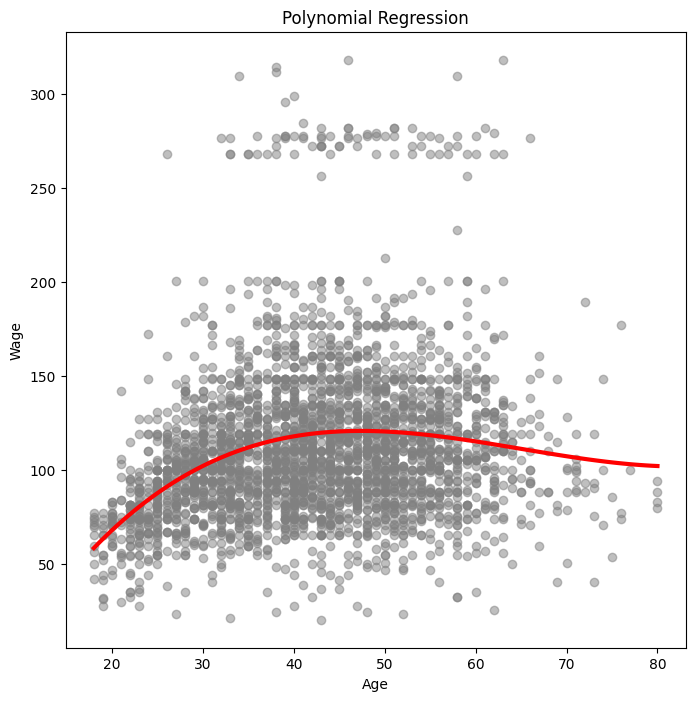

In [9]:
plot_wage_fit(age_df, y, age, poly_estimator, "Polynomial Regression")

### b)

In [10]:

kbins = KBinsDiscretizer(strategy="quantile")

step_pipeline = make_pipeline(kbins, ols)

grid_search_step = GridSearchCV(
    estimator=step_pipeline,
    param_grid={"kbinsdiscretizer__n_bins": range(2, 20)},
    cv=5,
    scoring="neg_mean_squared_error",
    verbose=1,
)

result_step = cross_validate(
    grid_search_step,
    pd.DataFrame({"age": age}),
    y,
    cv=outer_valid,
    scoring="neg_mean_squared_error",
    return_estimator=True,
)

print(result_step)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
{'fit_time': array([0.40277743]), 'score_time': array([0.0010047]), 'estimator': [GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('kbinsdiscretizer', KBinsDiscretizer()),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'kbinsdiscretizer__n_bins': range(2, 20)},
             scoring='neg_mean_squared_error', verbose=1)], 'test_score': array([-1585.28616749])}


In [11]:
result_step["estimator"][0].best_params_

{'kbinsdiscretizer__n_bins': 15}

In [12]:
step_estimator = result_step["estimator"][0].best_estimator_


<Axes: title={'center': 'Polynomial Regression'}, xlabel='Age', ylabel='Wage'>

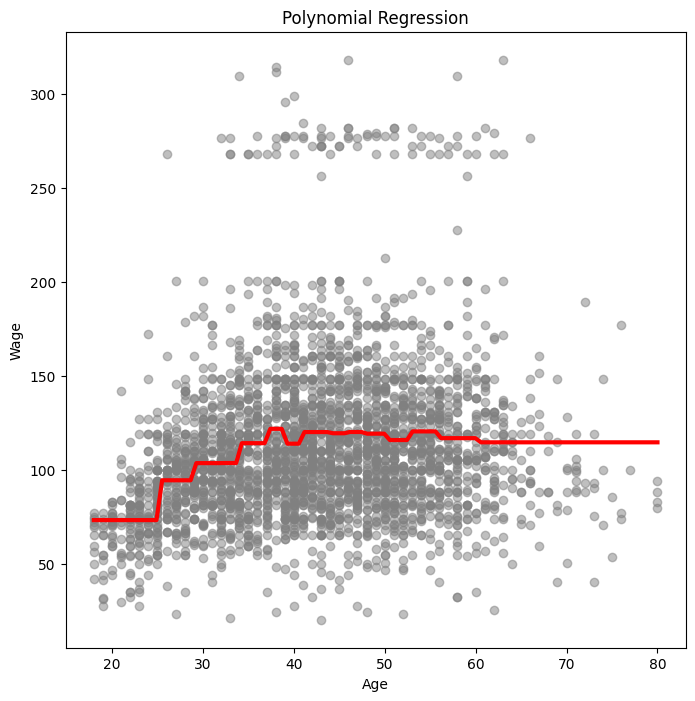

In [13]:
plot_wage_fit(age_df, y, age, step_estimator, "Polynomial Regression")